# Scalable Additive-Structure GP Classification (CUDA) (w/ KISS-GP)

## Introduction

This example shows how to use a `AdditiveGridInducingVariationalGP` module. This classifcation module is designed for when the function you’re modeling has an additive decomposition over dimension. This is equivalent to using a covariance function that additively decomposes over dimensions:

$$k(\mathbf{x},\mathbf{x'}) = \sum_{i=1}^{d}k([\mathbf{x}]_{i}, [\mathbf{x'}]_{i})$$

where $[\mathbf{x}]_{i}$ denotes the ith component of the vector $\mathbf{x}$. Example applications of this include use in Bayesian optimization, and when performing deep kernel learning. 

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic in the number of data points.


In this example, we’re performing classification on a two dimensional toy dataset that is:
- Defined in [-1, 1]x[-1, 1]
- Valued 1 in [-0.5, 0.5]x[-0.5, 0.5]
- Valued -1 otherwise

The above function doesn't have an obvious additive decomposition, but it turns out that this function is can be very well approximated by the kernel anyways.

In [1]:
# High-level imports
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make inline plots
%matplotlib inline

## Generate toy dataset

In [2]:
from torch.autograd import Variable

# Classifying points
# X is [-1, 1] X [-1, 1] 
# Y values are 1 inside [-0.5, 0.5] X [-0.5, 0.5]
# 201 points along each axis, 201^2 = 40,401 training points
n = 201
train_x = torch.zeros(n ** 2, 2)
train_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
train_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
train_y = (train_x[:, 0].abs().lt(0.5)).float() * (train_x[:, 1].abs().lt(0.5)).float() * 2 - 1
# Cuda the variables
train_x = Variable(train_x).cuda()
train_y = Variable(train_y).cuda()

In [3]:
# Neural net and optimizer imports
from torch import nn, optim
# Get the RBF kernel
# The GridInterpolationKernel is put on top the RBF kernel to interpolate it between
# the grid inducing points
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
# Gaussian likelihood is a Gaussian with noise added
# Bernoulli likelihood (warping input using normal CDF to [0,1])
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

## Define the model

In contrast to the most basic classification models, this model extends `AdditiveGridInducingVariationalGP`. This causes two key changes in the model. First, the base class specifically assumes that the input to `forward`, `x`, is to be additive decomposed. Thus, although the model below defines an `RBFKernel` as the covariance function, because we extend this base class, the additive decomposition discussed above will be imposed. 

Second, this model automatically assumes we will be using scalable kernel interpolation (SKI) for each dimension. Because of the additive decomposition, we only provide one set of grid bounds to the base class constructor, as the same grid will be used for all dimensions. It is recommended that you scale your training and test data appropriately.

In [4]:
# For GP Classification we use the AdditiveGridInducingVariationalGP model
class GPClassificationModel(gpytorch.models.AdditiveGridInducingVariationalGP):
    def __init__(self):
        super(GPClassificationModel, self).__init__(grid_size=100, grid_bounds=[(-1, 1)],
                                                    n_components=2)
        # Constant mean near 0
        self.mean_module = ConstantMean()
        # RBF kernel used as covariance module
        self.covar_module = RBFKernel()
        # Register the log length scale of the RBF kernel as a parameter to be trained
        self.register_parameter('log_outputscale',
                                nn.Parameter(torch.Tensor([0])))
        
    def forward(self,x):
        # Use the mean and covariance modules
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Scale the covariance matrix by lengthscale
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # The prediction is in the form of a Gaussian Random variable
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred
# Cuda the model and likelihood function
model = GPClassificationModel().cuda()
likelihood = BernoulliLikelihood().cuda()

## Training the model

Once the model has been defined, the training loop looks very similar to other variational models we've seen in the past. We will optimize the variational lower bound as our objective function. In this case, although variational inference in GPyTorch supports stochastic gradient descent, we choose to do batch optimization due to the relatively small toy dataset.

For an example of using the `AdditiveGridInducingVariationalGP` model with stochastic gradient descent, see the `dkl_mnist` example.

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.2)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, n_data=len(train_y))

# Training function
def train():
    # 25 iterations
    num_iter = 25
    for i in range(num_iter):
        # Zero out the gradients
        optimizer.zero_grad()
        # Output the model prediction
        output = model(train_x)
        # Calculate the loss of the prediction
        loss = -mll(output, train_y)
        loss.backward()
        # Report iteration results
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f' % (
            i + 1, num_iter, loss.data[0],
            model.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
        ))
        optimizer.step()

# See dkl_mnist.ipynb for explanation of use_toeplitz
with gpytorch.settings.use_toeplitz(False):
    # Time how long the training takes
    %time train()

Iter 1/25 - Loss: 23.488   log_lengthscale: 0.000
Iter 2/25 - Loss: 37.729   log_lengthscale: -0.200
Iter 3/25 - Loss: 13.422   log_lengthscale: -0.370
Iter 4/25 - Loss: 9.087   log_lengthscale: -0.552
Iter 5/25 - Loss: 15.782   log_lengthscale: -0.742
Iter 6/25 - Loss: 12.643   log_lengthscale: -0.932
Iter 7/25 - Loss: 3.719   log_lengthscale: -1.126
Iter 8/25 - Loss: 2.200   log_lengthscale: -1.323
Iter 9/25 - Loss: 1.363   log_lengthscale: -1.515
Iter 10/25 - Loss: 3.235   log_lengthscale: -1.699
Iter 11/25 - Loss: 2.570   log_lengthscale: -1.887
Iter 12/25 - Loss: 5.198   log_lengthscale: -2.080
Iter 13/25 - Loss: 3.051   log_lengthscale: -2.275
Iter 14/25 - Loss: 2.112   log_lengthscale: -2.468
Iter 15/25 - Loss: 1.688   log_lengthscale: -2.654
Iter 16/25 - Loss: 1.383   log_lengthscale: -2.833
Iter 17/25 - Loss: 1.373   log_lengthscale: -2.999
Iter 18/25 - Loss: 0.945   log_lengthscale: -3.158
Iter 19/25 - Loss: 1.236   log_lengthscale: -3.308
Iter 20/25 - Loss: 0.993   log_lengt

## Test the model

Next we test the model and plot the decision boundary. Despite the function we are optimizing not having an obvious additive decomposition, the model provides accurate results.

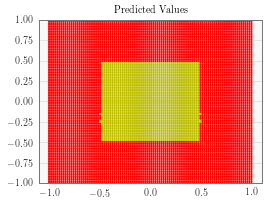

In [6]:
# Switch the model and likelihood into the evaluation mode
model.eval()
likelihood.eval()

# Start the plot, 4x3in
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# 10k test points on grid
n = 100
test_x = torch.zeros(n ** 2, 2)
test_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
test_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
# Cuda variable of test data
test_x = Variable(test_x).cuda()
# Make predictions
with gpytorch.settings.use_toeplitz(False):
    predictions = likelihood(model(test_x))

# define plotting function
def ax_plot(ax, rand_var, title):
    # ax = axes object
    # rand_var = predictions
    # title = plot title
    
    # Get the mean of the predictiono, check whether > 0.5: this returns 0 or 1
    # Multiply by 2 and subtract 1, resulting in label of -1 or 1
    # Put the data on the cpu as a numpy array
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.cpu().numpy()
    # Define colors to use
    color = []
    for i in range(len(pred_labels)):
        # 1 are yellow, -1 are red
        if pred_labels[i] == 1:
            color.append('y')
        else:
            color.append('r')
    # Plot the data
    ax.scatter(test_x.data[:, 0].cpu().numpy(), test_x.data[:, 1].cpu().numpy(), color=color, s=1)
    ax.set_ylim([-1, 1])
    ax.set_title(title)

ax_plot(observed_ax, predictions, 'Predicted Values')    